# Conditional Flow

Previously, noise data was chopped up into segments X long and fed into a normalising flow. The flow would do its thing and we could run in reverse to produce new segments of noise data also X datapoints long. This is fine, but what if we want to produce many seconds of noise data? At a sampling rate of 4096Hz that is going to require a normalising flow to take in thousands of datapoints per segment. This would be computationally very arduous to train  - instead, we could use a conditional flow. 

(See the *glasflow* [conditional example](https://github.com/igr-ml/glasflow/blob/main/examples/conditional_example.ipynb) from which code here is adapted.)

From the example above, there is a set of 'classes' in which a bunch of datapoints belong, collected in different regions. Just as in the normalising flow, this is adaptable to our situation by expanding the dimensions. Or, for our understanding, we could initially keep the dimensions the same. In the example the datapoints are (x,y) with 4 classes, [0 1 2 3]. The conditional flow takes the classes as the conditioning data and learns the distributions so that when you run it in reverse, you will need to give it a condition, say '0', then it will generate a point that is most likely to be somewhere in the middle of the 0 class blob. 

In our case then, we can split our data into segments of 6 datapoints. We then could choose the first 4 datapoints to correspond to the 'classes' and the last 2 datapoints to be the data (x,y). The flow would then learn that for this particular pattern of 4 datapoints, the next 2 lie in some region goverened by a probability distribution. Then, when we run in reverse we can give the flow 4 datapoints and create 2 new datapoints to attach to the end.

Then, we can simply expand this. We can create a flow that learns the next 8 datapoints given the previous 24, and so on. This is a useful idea because once we have a well trained flow, it can then sample new datapoints which can then be fed in as the next segment of conditional data. Looping this many times to create long segments of noise data.

In [ ]:
#IMPORTS

! pip install git+https://github.com/igr-ml/glasflow.git
from glasflow import RealNVP
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
import copy
import seaborn as sns

  Cloning https://github.com/igr-ml/glasflow.git to /tmp/pip-req-build-d5pk_ybp
  Running command git clone -q https://github.com/igr-ml/glasflow.git /tmp/pip-req-build-d5pk_ybp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# Data

Following cells import the data, split the data into a samples array - as in the NF code.

In [ ]:
#Install gwpy
! pip install -q 'gwpy==1.0.1'

from gwpy.timeseries import TimeSeries
import numpy as np
import matplotlib.pyplot as plt


#Select the length of downloaded sample in seconds
n_seconds = 24000

#Segment of GPS times
segment = (1243435410,1243437410+n_seconds) 

#Fetch data from L1
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True) #cache stores so doesnt need to be downloaded again

data = np.array(ldata.data)

Fetched 7 URLs from www.gw-openscience.org for [1243435410 .. 1243461410))
Reading data... 

/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


[Done]
Reading data... 

/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:917: UserWarning: TimeSeries.crop given start smaller than current start, crop will begin when the Series actually starts.
  % type(self).__name__)


[Done]
Reading data... [Done]
Reading data... [Done]
Reading data... [Done]
Reading data... [Done]
Reading data... [Done]


In [ ]:
#Select the number of datapoints and conditional data - This must add to be a factor of 4096. e.g 16,32,64,128,256,512...
n_datapoints = 12
n_conditional = 500
#Used multiple times is the sum
n_total = n_datapoints + n_conditional

#Scale the data
  #Find the max value
maximum_value = max(abs(data))
  #Divide all values by max
data = data/maximum_value

#Calculates split in size
n_split = np.shape(data)[0]/(n_total)

#Split to get n datapoints per set
data_split = np.split(data,n_split)

samples = np.array(data_split)
print('The final samples array size is', np.shape(samples))

#Create copy for fft use
samples_2 = samples.copy

The final samples array size is (208000, 512)


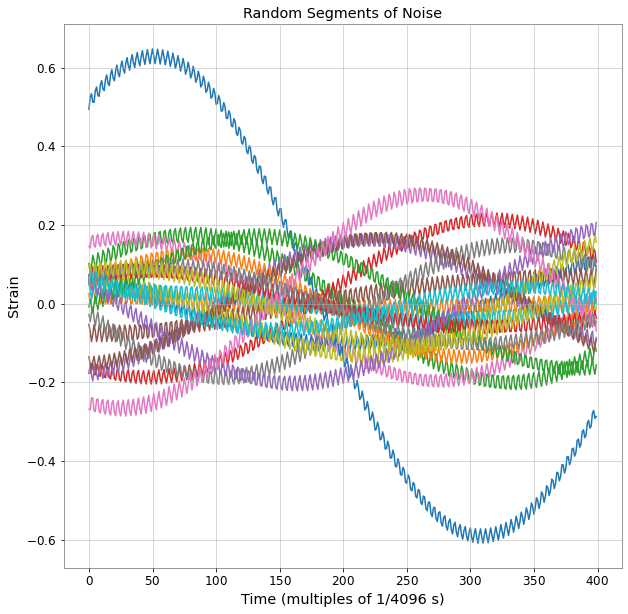

In [ ]:
#Choose random segments to sample data 
n_segments = np.random.choice(len(ldata), size = (20,))

fig = plt.figure(figsize=(10,10))

#plot the 400 datapoints around the randomly selected point
for i in n_segments:
  plt.plot(data[i-200:i+200])

plt.title('Random Segments of Noise')
plt.ylabel('Strain')
plt.xlabel('Time (multiples of 1/4096 s)')
plt.show()

The data needs to be split an extra time now, seperating out the conditional data.

In [ ]:
#Split data into conditional and training data

print('The samples array begins with shape:', np.shape(samples))

#Segment off conditional data
conditional_data = samples[:,0:n_conditional]
print( 'Conditional array shape is:', np.shape(conditional_data))

#Keep only non_conditional data in samples array
samples = np.delete(samples, np.arange(0,n_conditional), axis=1)

print('The samples array ends with shape:', np.shape(samples))

The samples array begins with shape: (208000, 512)
Conditional array shape is: (208000, 500)
The samples array ends with shape: (208000, 12)


Create the flow:

In [ ]:
device = 'cuda'

flow = RealNVP(
    n_inputs=n_datapoints,
    n_transforms=2,
    n_conditional_inputs=n_conditional,
    n_neurons=16,
    batch_norm_between_transforms=True,
    dropout_probability = 0.1
)
flow.to(device)
print(f'Created flow and sent to {device}')

Created flow and sent to cuda


In [ ]:
optimiser = torch.optim.Adam(flow.parameters(), lr=2e-4, weight_decay=1e-6)

#Configure training
epochs = 1500
patience = 30
batch_size = 4096

#Split data into training and validation
from sklearn.model_selection import train_test_split


#Load data into tensors
x_train, x_val, y_train, y_val = train_test_split(samples, conditional_data, test_size = 0.25)

x_train_tensor = torch.from_numpy(x_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

x_val_tensor = torch.from_numpy(x_val.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.astype(np.float32))
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

#Training

In [ ]:
%%time
loss = dict(train=[], val=[])

for i in range(epochs):
    flow.train()
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        #print('For training, x is: ', np.shape(x), ' y is: ', np.shape(y))
        x = x.to(device)
        y = y.to(device)
        optimiser.zero_grad()
        _loss = -flow.log_prob(x, conditional=y).mean()
        _loss.backward()
        optimiser.step()
        train_loss += _loss.item()
    loss['train'].append(train_loss / len(train_loader))

    flow.eval()
    val_loss = 0.0
    for batch in val_loader:
        x, y = batch
        #print('For validation, x is: ', np.shape(x), ' y is: ', np.shape(y))
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _loss = -flow.log_prob(x, conditional=y).mean().item()
        val_loss += _loss
    loss['val'].append(val_loss / len(val_loader))
    if not i % 10:
        print(f"Epoch {i} - train: {loss['train'][-1]:.3f}, val: {loss['val'][-1]:.3f}")

flow.eval()
print('Finished training')

Epoch 0 - train: -15.094, val: -19.364
Epoch 10 - train: -43.482, val: -39.915
Epoch 20 - train: -47.616, val: -44.557
Epoch 30 - train: -48.603, val: -46.474
Epoch 40 - train: -49.621, val: -48.982
Epoch 50 - train: -50.549, val: -48.056
Epoch 60 - train: -48.734, val: -45.799
Epoch 70 - train: -52.465, val: -52.906
Epoch 80 - train: -51.609, val: -51.846
Epoch 90 - train: -52.644, val: -52.607
Epoch 100 - train: -49.566, val: -41.248
Epoch 110 - train: -51.893, val: -50.660
Epoch 120 - train: -52.216, val: -49.148
Epoch 130 - train: -51.221, val: -50.190
Epoch 140 - train: -52.703, val: -49.362
Epoch 150 - train: -53.629, val: -50.495
Epoch 160 - train: -54.189, val: -49.966
Epoch 170 - train: -53.430, val: -49.181
Epoch 180 - train: -55.276, val: -49.271
Epoch 190 - train: -51.056, val: -50.237
Epoch 200 - train: -52.410, val: -53.332
Epoch 210 - train: -52.191, val: -49.875
Epoch 220 - train: -53.952, val: -53.736
Epoch 230 - train: -52.965, val: -53.048
Epoch 240 - train: -55.042,

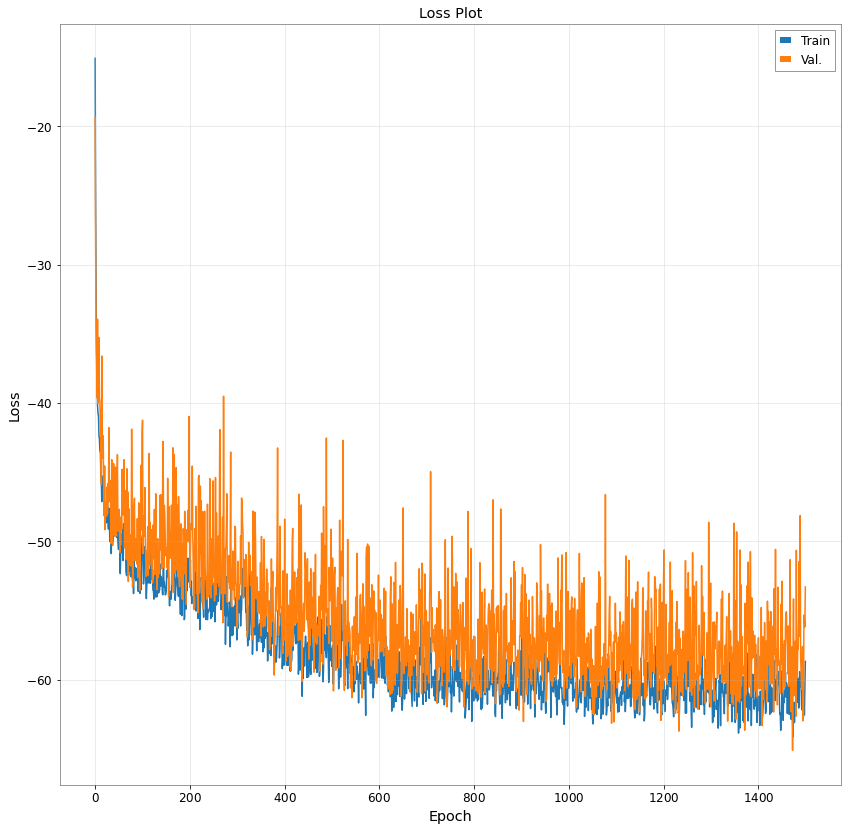

In [ ]:
flow.eval()
fig = plt.figure(figsize=(14,14))
plt.plot(loss['train'], label='Train')
plt.plot(loss['val'], label='Val.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.show()

#Latent Space

The flow needs to produce normals in the latent space, the number of histograms will be equal to the number of conditional datapoints.

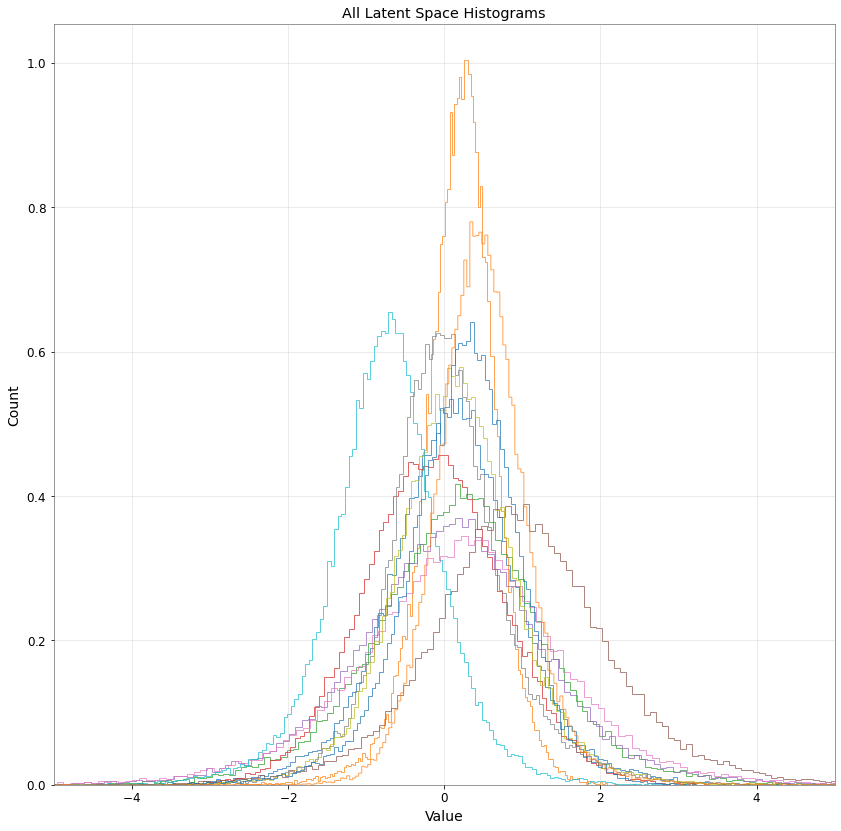

In [ ]:
#flow forward using validation data
with torch.no_grad():
    z, _ = flow.forward(x_val_tensor.to(device), y_val_tensor.to(device))
    z = z.cpu().numpy()

#Plot
fig = plt.figure(figsize=(14,14))

for i in range(0,np.shape(z)[1]):
  plt.hist(x=z[:,i], bins='auto', alpha=0.7, density=True, histtype='step')
  
plt.xlabel("Value", size=14)
plt.ylabel("Count", size=14)
plt.title("All Latent Space Histograms")
plt.grid(which='both', alpha=0.5)
plt.xlim(-5,5)
plt.show()

#Using the Flow

The next cells generate data using the element 1 of the conditional data

In [ ]:
n = 1
flow.eval()
y_con = np.reshape(conditional_data[1],(1,n_conditional))
conditional = torch.from_numpy(y_con.astype(np.float32)).to(device)
print(np.shape(conditional))

with torch.no_grad():
    generated = flow.sample(n, conditional=conditional)
generated = generated.cpu().numpy()

torch.Size([1, 500])


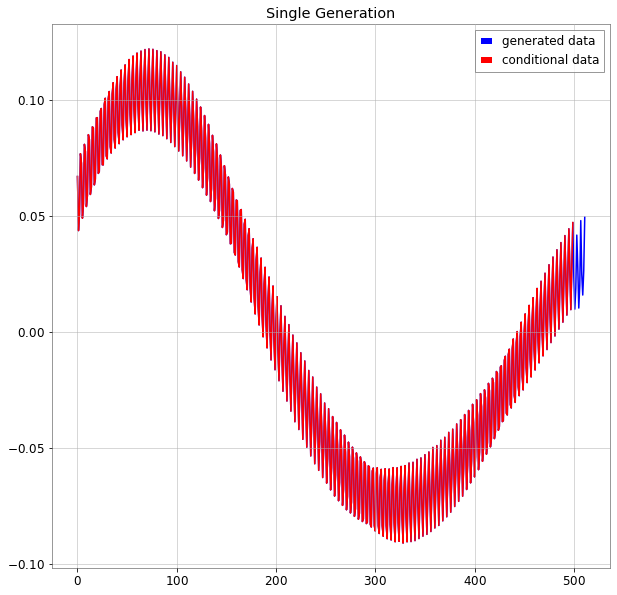

In [ ]:
fig = plt.figure(figsize=(10,10))

final_plot_data = np.concatenate((y_con[0],generated[0]))

plt.plot(final_plot_data, color='blue', label='generated data')
plt.plot(y_con[0], color='red', label='conditional data')
plt.legend()
plt.title('Single Generation')
plt.show()

The next cells repeat this n times and plot.

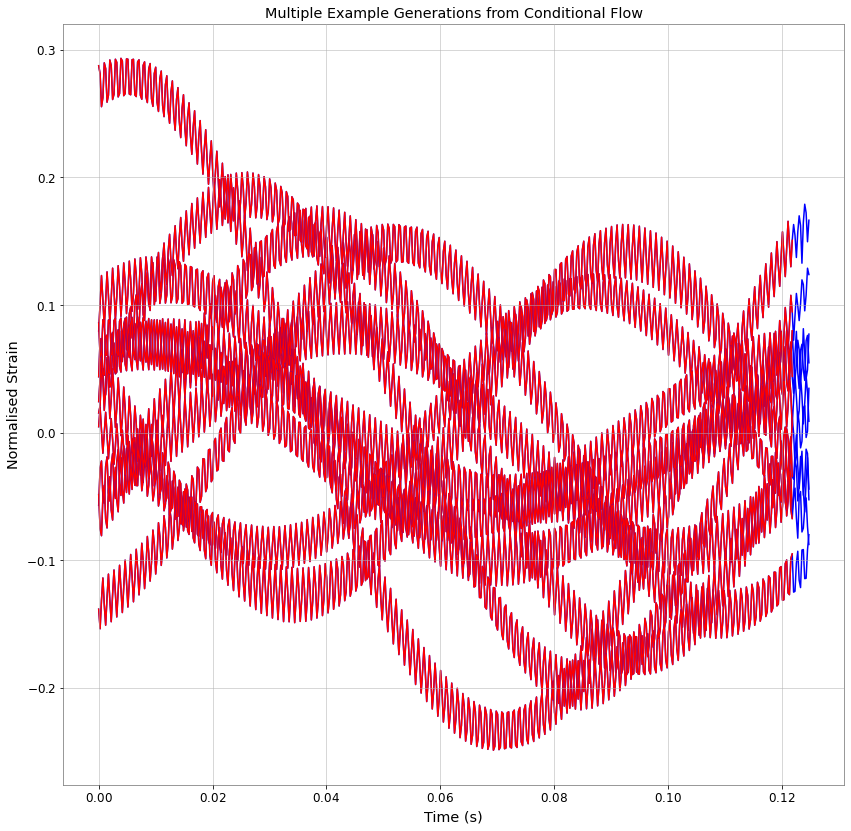

In [ ]:
#Number of examples to generate
n = 10

#Random elements of data to plot
idx = np.random.randint(0,samples.shape[0],n)

#Times for plot
times_total = np.arange(0,n_total,1)*(1/4096)
times_cond = np.arange(0,n_conditional,1)*(1/4096)

fig = plt.figure(figsize=(14,14))

for i in idx:
  #Get conditional data
  y_con = np.reshape(conditional_data[i],(1,n_conditional))
  conditional = torch.from_numpy(y_con.astype(np.float32)).to(device)

  #Generate from conditional
  with torch.no_grad():
    generated = flow.sample(1, conditional=conditional)
  generated = generated.cpu().numpy()

  #Join for plotting purposes
  final_plot_data = np.concatenate((y_con[0],generated[0]))

  #Plot
  plt.plot(times_total,final_plot_data, color='blue')
  plt.plot(times_cond, y_con[0], color='red') 

  plt.ylabel('Normalised Strain')
  plt.xlabel('Time (s)')


plt.title('Multiple Example Generations from Conditional Flow')
plt.show()

#Looping

Now the flow uses generated data to loop into the conditional segment of the next generation. This repeats n times. This is compared to the actual data. Strictly, this is not completely useful as the generated data is unlikely to exactly match the original, it should just be more likely to contain the same characteristics of the whole set of training data. 

In [ ]:
#Create a loop to generate more data
print()
#Initial conditions
i=0
n=10 #number of times to loop
master = conditional_data[0]
loop_con = master

while i<n:
  loop_con_size = np.shape(loop_con)[0]
  loop_con = master[loop_con_size-n_conditional:loop_con_size]

  con = np.reshape(loop_con,(1,n_conditional))
  con_torch = torch.from_numpy(con.astype(np.float32)).to(device) 

  #Generate from conditional
  with torch.no_grad():
    loop_generated = flow.sample(1, conditional = con_torch)
  loop_generated = loop_generated.cpu().numpy()
  #Join for plotting purposes
  master = np.concatenate((master,loop_generated[0]))
  i+=1


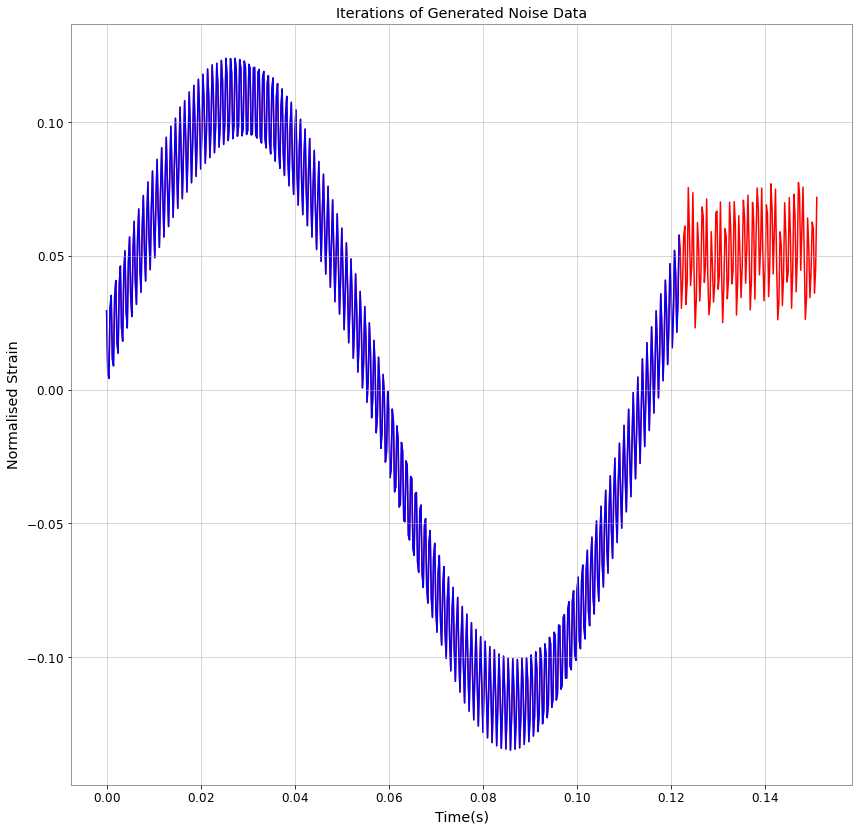

In [ ]:
times = np.arange(0,len(master),1)*(1/4096)
times_con = np.arange(0,n_conditional,1)*(1/4096)

#Plot
fig = plt.figure(figsize=(14,14))
plt.plot(times,master, color = 'red', label = 'generated data')
plt.plot(times_con,con.T, color='blue', label = 'initial conditional data')

#plt.plot(data[0:n_conditional+(n_datapoints*n)], color='blue', label = 'original data')
plt.title('Iterations of Generated Noise Data')
#plt.xticks(np.arange(0,52,2))
plt.ylabel('Normalised Strain')
plt.xlabel('Time(s)')
plt.show()